# Deep learning example on image tiles

We will show, as an example, how to train a Dense Net which predicts cell types Xenium data from an associated H&E image.

In particular this example shows that:
- We can easily access and combine images and annotations across different technologies. For the sake of the example here we use the H&E image from Visium data, and the cell type information from overlapping Xenium data. Remarkably, the two modalities are spatially aligned via an affine transformation.
- We generate image tiles with full control of the spatial extent and the pixel resolution.
- We interface with popular frameworks for deep learning: Monai and PyTorch Lightning.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
from typing import Dict

import numpy as np
import pandas as pd
import pytorch_lightning as pl
import scanpy as sc
import torch
import torch.multiprocessing as mp
import torch.nn.functional as F
import torchvision
from anndata import AnnData
from monai.networks.nets import DenseNet121
from napari_spatialdata import Interactive
from pytorch_lightning import LightningDataModule
from pytorch_lightning.callbacks import LearningRateMonitor
from pytorch_lightning.callbacks.progress import TQDMProgressBar
from pytorch_lightning.loggers import CSVLogger
from spatial_image import SpatialImage
from spatialdata import SpatialData, read_zarr, transform
from spatialdata.dataloader.datasets import ImageTilesDataset
from spatialdata.transformations import get_transformation
from torch.nn import CrossEntropyLoss
from torch.optim import Adam
from torch.utils.data import DataLoader
from tqdm import tqdm

mp.set_start_method("spawn", force=True)

/Users/macbook/miniconda3/envs/ome/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/macbook/miniconda3/envs/ome/lib/python3.10/site-packages/geopandas/_compat.py:123: UserWarning: The Shapely GEOS version (3.11.1-CAPI-1.17.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(
/Users/macbook/embl/projects/basel/napari-spatialdata/src/napari_spatialdata/interactive.py:16: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_

## Preparing the data

### Getting the Zarr files

We will need two Zarr files, one for Xenium data and one for Visium data. You can obtain these files by running [this notebook](https://github.com/scverse/spatialdata-notebooks/blob/main/notebooks/paper_reproducibility/xenium_and_visium.ipynb).

Alternatively, you can download a zipped version of the data from here: [Xenium data](https://s3.embl.de/spatialdata/spatialdata-sandbox/xenium_rep1_io.zip), [Visium data](https://s3.embl.de/spatialdata/spatialdata-sandbox/visium_associated_xenium_io.zip). 

If you download the data, please make it discoverable in the paths specified next (you can use symlink to achieve this).

In [3]:
print("current working directory:", os.getcwd())
SPATIALDATA_SANDBOX_PATH = "../../../spatialdata-sandbox"
assert os.path.isdir(
    SPATIALDATA_SANDBOX_PATH
), f"{SPATIALDATA_SANDBOX_PATH} not found, please use symlinks to make it available"

XENIUM_SDATA_PATH = os.path.join(SPATIALDATA_SANDBOX_PATH, "xenium_rep1_io/data.zarr")
VISIUM_SDATA_PATH = os.path.join(SPATIALDATA_SANDBOX_PATH, "visium_associated_xenium_io/data.zarr")

assert os.path.isdir(XENIUM_SDATA_PATH)
assert os.path.isdir(VISIUM_SDATA_PATH)

xenium_sdata = read_zarr(XENIUM_SDATA_PATH)
visium_sdata = read_zarr(VISIUM_SDATA_PATH)

assert "celltype_major" in xenium_sdata.table.obs, (
    "The Xenium data does not contain the cell types annotation; it seems that it refers to the Xenium"
    "Zarr data that has not been processed with the analysis notebook we refer in the 'Getting the Zarr"
    "files section'."
)

current working directory: /Users/macbook/embl/projects/basel/spatialdata-notebooks/notebooks/examples
2023-05-04 17:56:20,830 - root_attr: channels_metadata
2023-05-04 17:56:20,830 - root_attr: multiscales
2023-05-04 17:56:20,831 - datasets [{'coordinateTransformations': [{'scale': [1.0, 1.0, 1.0], 'type': 'scale'}], 'path': '0'}, {'coordinateTransformations': [{'scale': [1.0, 2.0, 2.0], 'type': 'scale'}], 'path': '1'}, {'coordinateTransformations': [{'scale': [1.0, 4.000310366232154, 4.0], 'type': 'scale'}], 'path': '2'}, {'coordinateTransformations': [{'scale': [1.0, 8.000620732464307, 8.0], 'type': 'scale'}], 'path': '3'}, {'coordinateTransformations': [{'scale': [1.0, 16.001241464928615, 16.003615002259377], 'type': 'scale'}], 'path': '4'}]
2023-05-04 17:56:20,833 - resolution: 0
2023-05-04 17:56:20,833 -  - shape ('c', 'y', 'x') = (1, 25778, 35416)
2023-05-04 17:56:20,834 -  - chunks =  ['1', '4096 (+ 1202)', '4096 (+ 2648)']
2023-05-04 17:56:20,834 -  - dtype = uint16
2023-05-04

Let's create a new `SpatialData` object with just the elements we are interest in. We will predict the Xenium cell types from the Visium image, so let's grab the cell circles and the table from the Xenium data, and the full resolution H&E image from Visium.

In [4]:
merged = SpatialData(
    images={
        "CytAssist_FFPE_Human_Breast_Cancer_full_image": visium_sdata.images[
            "CytAssist_FFPE_Human_Breast_Cancer_full_image"
        ],
    },
    shapes={
        "cell_circles": xenium_sdata.shapes["cell_circles"],
        "cell_boundaries": xenium_sdata.shapes["cell_boundaries"],
    },
    table=xenium_sdata.table,
)

For the sake of reducing the computational requirements to run this example, let's spatially subset the data.

In [5]:
min_coordinate = [12790, 12194]
max_coordinate = [15100, 15221]
merged = merged.query.bounding_box(
    min_coordinate=min_coordinate,
    max_coordinate=max_coordinate,
    axes=["y", "x"],
    target_coordinate_system="aligned",
)

In [96]:
21500 / 38

565.7894736842105

In [95]:
visium_sdata

SpatialData object with:
├── Images
│     ├── 'CytAssist_FFPE_Human_Breast_Cancer_full_image': MultiscaleSpatialImage[cyx] (3, 21571, 19505), (3, 10785, 9752), (3, 5392, 4876), (3, 2696, 2438), (3, 1348, 1219)
│     ├── 'CytAssist_FFPE_Human_Breast_Cancer_hires_image': SpatialImage[cyx] (3, 2000, 1809)
│     └── 'CytAssist_FFPE_Human_Breast_Cancer_lowres_image': SpatialImage[cyx] (3, 600, 543)
├── Shapes
│     └── 'CytAssist_FFPE_Human_Breast_Cancer': GeoDataFrame shape: (4992, 2) (2D shapes)
└── Table
      └── AnnData object with n_obs × n_vars = 4992 × 18085
    obs: 'in_tissue', 'array_row', 'array_col', 'spot_id', 'region', 'dataset', 'clone'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial', 'spatialdata_attrs', 'region_colors', 'clone_colors'
    obsm: 'spatial': AnnData (4992, 18085)
with coordinate systems:
▸ 'aligned', with elements:
        CytAssist_FFPE_Human_Breast_Cancer_full_image (Images), CytAssist_FFPE_Human_Breast_Cancer (Shapes)
▸ 'downscaled_hires'

In [43]:
adata_polygons.uns["spatialdata_attrs"]["region"] = "cell_boundaries"
adata_polygons.obs["region"] = "cell_boundaries"

del merged.table
merged.table = adata_polygons

In [94]:
# Interactive(merged)
Interactive(visium_sdata)

CytAssist_FFPE_Human_Breast_Cancer_full_image: 0.19387578964233398
CytAssist_FFPE_Human_Breast_Cancer_hires_image: 0.06678891181945801
CytAssist_FFPE_Human_Breast_Cancer_lowres_image: 0.08526992797851562
CytAssist_FFPE_Human_Breast_Cancer: 3.0244739055633545


2023-05-04 21:06:53.388 python[7815:27399369] IMKClient Stall detected, *please Report* your user scenario attaching a spindump (or sysdiagnose) that captures the problem - (imkxpc_bundleIdentifierWithReply:) block performed very slowly (4.81 secs).
2023-05-04 21:07:09.551 python[7815:27399369] +[CATransaction synchronize] called within transaction


Here is a visualization of the image and cell type data. Notice how the Visium image is rotated with respect to the Xenium data.

![image.png](attachments/dense_net_cell_types.png)

Let's compute the mean Xenium cell diamater, we will use this to choose an appropriate image tile size.

In [6]:
circles = merged["cell_circles"]
t = get_transformation(circles, "aligned")

transformed_circles = transform(circles, t)
xenium_circles_diameter = 2 * np.mean(transformed_circles.radius)

Let's find the list of all the cell types we are dealing with.

In [7]:
cell_types = merged.table.obs["celltype_major"].cat.categories.tolist()

We now effortlessly define a PyTorch `Dataset` for the `SpatialData` object using the class `ImageTileDataset()`.

In particular we want the following.
* We want the tile size to be 32 x 32 pixels.
* At the same time, we want each tile to have a spatial extent of 3 times the average Xenium cell diameter
* For each tile we want to extract the value of the `celltype_major` categorical column and encode this into a one-hot vector. We will use the `torchvision` transforms paradigma for achieving this.


**Technical note.**
There are some limitations when using PyTorch inside a Jupyter Notebook. Here we would need a function, that we call `my_transform()`, that we would use to apply a data transformation to the dataset. The function can't be defined here in the notebook so we will import it from a separate `Python` file. For more details please see here: https://stackoverflow.com/a/65001152.

Here is the function that we would like to define.
```python
def my_transform(sdata: SpatialData) -> tuple[torch.tensor, torch.tensor]:
    tile = sdata['CytAssist_FFPE_Human_Breast_Cancer_full_image'].data.compute()
    tile = torch.tensor(tile)
    
    expected_category = sdata.table.obs['celltype_major'].values[0]
    expected_category = cell_types.index(expected_category)
    cell_type = F.one_hot(
        torch.tensor(expected_category), num_classes=len(cell_types)
    )
    return tile, cell_type
```

In [8]:
# let's import the above function
from densenet_utils import my_transform

dataset = ImageTilesDataset(
    sdata=merged,
    regions_to_images={"cell_circles": "CytAssist_FFPE_Human_Breast_Cancer_full_image"},
    tile_dim_in_units=3 * xenium_circles_diameter,
    tile_dim_in_pixels=32,
    target_coordinate_system="aligned",
    transform=my_transform,
)

dataset[0]

(tensor([[[245., 255., 252.,  ..., 255., 255., 254.],
          [253., 254., 251.,  ..., 254., 255., 255.],
          [255., 254., 253.,  ..., 251., 252., 254.],
          ...,
          [253., 255., 255.,  ..., 255., 252., 253.],
          [249., 254., 254.,  ..., 254., 250., 251.],
          [242., 250., 250.,  ..., 254., 250., 255.]],
 
         [[174., 188., 197.,  ..., 205., 203., 189.],
          [188., 192., 197.,  ..., 203., 204., 189.],
          [198., 197., 202.,  ..., 200., 204., 186.],
          ...,
          [195., 206., 205.,  ..., 218., 216., 177.],
          [187., 198., 199.,  ..., 222., 212., 177.],
          [180., 191., 193.,  ..., 223., 210., 187.]],
 
         [[219., 230., 225.,  ..., 230., 237., 236.],
          [228., 226., 223.,  ..., 229., 238., 237.],
          [231., 225., 224.,  ..., 226., 238., 233.],
          ...,
          [233., 236., 236.,  ..., 237., 238., 213.],
          [223., 230., 231.,  ..., 240., 233., 212.],
          [213., 224., 226.,  .

Let's now define a PyTorch Lightning data module to reduce the amount of boilerplate code we need to write.

In [9]:
class TilesDataModule(LightningDataModule):
    def __init__(self, batch_size: int, num_workers: int, dataset: torch.utils.data.Dataset):
        super().__init__()

        self.batch_size = batch_size
        self.num_workers = num_workers
        self.dataset = dataset

    def setup(self, stage=None):
        n_train = int(len(self.dataset) * 0.7)
        n_val = int(len(self.dataset) * 0.2)
        n_test = len(self.dataset) - n_train - n_val
        self.train, self.val, self.test = torch.utils.data.random_split(
            self.dataset,
            [n_train, n_val, n_test],
            generator=torch.Generator().manual_seed(42),
        )

    def train_dataloader(self):
        return DataLoader(
            self.train,
            batch_size=self.batch_size,
            num_workers=self.num_workers,
            shuffle=True,
        )

    def val_dataloader(self):
        return DataLoader(
            self.val,
            batch_size=self.batch_size,
            num_workers=self.num_workers,
            shuffle=False,
        )

    def test_dataloader(self):
        return DataLoader(
            self.test,
            batch_size=self.batch_size,
            num_workers=self.num_workers,
            shuffle=False,
        )

    def predict_dataloader(self):
        return DataLoader(
            self.dataset,
            batch_size=self.batch_size,
            num_workers=self.num_workers,
            shuffle=False,
        )

Let's define the Dense Net, that we import from Monai.

In [10]:
class DenseNetModel(pl.LightningModule):
    def __init__(self, learning_rate: float, in_channels: int, num_classes: int):
        super().__init__()

        # store hyperparameters
        self.save_hyperparameters()

        self.loss_function = CrossEntropyLoss()

        # make the model
        self.model = DenseNet121(spatial_dims=2, in_channels=in_channels, out_channels=num_classes)

    def forward(self, x) -> torch.Tensor:
        return self.model(x)

    def _compute_loss_from_batch(self, batch: Dict[str, torch.Tensor], batch_idx: int) -> float:
        inputs = batch[0]
        labels = batch[1]

        outputs = self.model(inputs)
        return self.loss_function(outputs, labels)

    def training_step(self, batch: Dict[str, torch.Tensor], batch_idx: int) -> Dict[str, float]:
        # compute the loss
        loss = self._compute_loss_from_batch(batch=batch, batch_idx=batch_idx)

        # perform logging
        self.log("training_loss", loss, batch_size=len(batch[0]))

        return {"loss": loss}

    def validation_step(self, batch: Dict[str, torch.Tensor], batch_idx: int) -> float:
        loss = self._compute_loss_from_batch(batch=batch, batch_idx=batch_idx)

        imgs, labels = batch
        acc = self.compute_accuracy(imgs, labels)
        # By default logs it per epoch (weighted average over batches), and returns it afterwards
        self.log("test_acc", acc)

        return loss

    def test_step(self, batch, batch_idx):
        imgs, labels = batch
        acc = self.compute_accuracy(imgs, labels)
        # By default logs it per epoch (weighted average over batches), and returns it afterwards
        self.log("test_acc", acc)

    def predict_step(self, batch, batch_idx: int, dataloader_idx: int = 0):
        imgs, labels = batch
        preds = self.model(imgs).argmax(dim=-1)
        return preds

    def compute_accuracy(self, imgs, labels):
        preds = self.model(imgs).argmax(dim=-1)
        labels_value = torch.argmax(labels, dim=-1)
        acc = (labels_value == preds).float().mean()
        return acc

    def configure_optimizers(self) -> Adam:
        return Adam(self.model.parameters(), lr=self.hparams.learning_rate)

We are ready to train the model!

In [11]:
import os

import numpy as np
import pytorch_lightning as pl
import torch
import torchvision
from pytorch_lightning.callbacks import LearningRateMonitor
from pytorch_lightning.callbacks.progress import TQDMProgressBar
from pytorch_lightning.loggers import CSVLogger

if __name__ == "__main__":
    pl.seed_everything(7)

    PATH_DATASETS = os.environ.get("PATH_DATASETS", "..")
    BATCH_SIZE = 4096 if torch.cuda.is_available() else 64
    NUM_WORKERS = 10 if torch.cuda.is_available() else 8
    print(f"Using {BATCH_SIZE} batch size.")
    print(f"Using {NUM_WORKERS} workers.")

    tiles_data_module = TilesDataModule(batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, dataset=dataset)

    tiles_data_module.setup()
    train_dl = tiles_data_module.train_dataloader()
    val_dl = tiles_data_module.val_dataloader()
    test_dl = tiles_data_module.test_dataloader()

    num_classes = len(cell_types)
    in_channels = dataset[0][0].shape[0]

    model = DenseNetModel(
        learning_rate=1e-5,
        in_channels=in_channels,
        num_classes=num_classes,
    )
    import logging

    logging.basicConfig(level=logging.INFO)

    trainer = pl.Trainer(
        max_epochs=2,
        accelerator="auto",
        devices=1 if torch.cuda.is_available() else None,  # limiting got iPython runs
        logger=CSVLogger(save_dir="logs/"),
        callbacks=[
            LearningRateMonitor(logging_interval="step"),
            TQDMProgressBar(refresh_rate=5),
        ],
        log_every_n_steps=20,
    )

    trainer.fit(model, datamodule=tiles_data_module)
    trainer.test(model, datamodule=tiles_data_module)

Global seed set to 7


Using 64 batch size.
Using 8 workers.


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | loss_function | CrossEntropyLoss | 0     
1 | model         | DenseNet121      | 7.0 M 
---------------------------------------------------
7.0 M     Trainable params
0         Non-trainable params
7.0 M     Total params
27.852    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/Users/macbook/miniconda3/envs/ome/lib/python3.10/site-packages/geopandas/_compat.py:123: UserWarning: The Shapely GEOS version (3.11.1-CAPI-1.17.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(
/Users/macbook/embl/projects/basel/spatialdata/src/spatialdata/__init__.py:9: UserWarning: Geopandas was set to use PyGEOS, changing to shapely 2.0 with:

	geopandas.options.use_pygeos = True

If you intended to use PyGEOS, set the option to False.
  _check_geopandas_using_shapely()
/Users/macbook/miniconda3/envs/ome/lib/python3.10/site-packages/geopandas/_compat.py:123: UserWarning: The Shapely GEOS version (3.11.1-CAPI-1.17.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(
/Users/macbook/embl/projects/basel/spatialdata/src/spatialdata/__init__.py:9: UserWarning: Geopandas was set to use PyGEOS, changing to 

Epoch 0:   0%|                                                                                                            | 0/26 [00:00<?, ?it/s]

/Users/macbook/miniconda3/envs/ome/lib/python3.10/site-packages/geopandas/_compat.py:123: UserWarning: The Shapely GEOS version (3.11.1-CAPI-1.17.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(
/Users/macbook/embl/projects/basel/spatialdata/src/spatialdata/__init__.py:9: UserWarning: Geopandas was set to use PyGEOS, changing to shapely 2.0 with:

	geopandas.options.use_pygeos = True

If you intended to use PyGEOS, set the option to False.
  _check_geopandas_using_shapely()
/Users/macbook/miniconda3/envs/ome/lib/python3.10/site-packages/geopandas/_compat.py:123: UserWarning: The Shapely GEOS version (3.11.1-CAPI-1.17.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(
/Users/macbook/embl/projects/basel/spatialdata/src/spatialdata/__init__.py:9: UserWarning: Geopandas was set to use PyGEOS, changing to 

Epoch 0:  77%|████████████████████████████████████████████████████████████▊                  | 20/26 [01:15<00:22,  3.78s/it, loss=2.2, v_num=14]
Validation: 0it [00:00, ?it/s]

/Users/macbook/miniconda3/envs/ome/lib/python3.10/site-packages/geopandas/_compat.py:123: UserWarning: The Shapely GEOS version (3.11.1-CAPI-1.17.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(
/Users/macbook/embl/projects/basel/spatialdata/src/spatialdata/__init__.py:9: UserWarning: Geopandas was set to use PyGEOS, changing to shapely 2.0 with:

	geopandas.options.use_pygeos = True

If you intended to use PyGEOS, set the option to False.
  _check_geopandas_using_shapely()
/Users/macbook/miniconda3/envs/ome/lib/python3.10/site-packages/geopandas/_compat.py:123: UserWarning: The Shapely GEOS version (3.11.1-CAPI-1.17.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(
/Users/macbook/embl/projects/basel/spatialdata/src/spatialdata/__init__.py:9: UserWarning: Geopandas was set to use PyGEOS, changing to 


Epoch 1:   0%|                                                                                        | 0/26 [00:00<?, ?it/s, loss=2.2, v_num=14]

/Users/macbook/miniconda3/envs/ome/lib/python3.10/site-packages/geopandas/_compat.py:123: UserWarning: The Shapely GEOS version (3.11.1-CAPI-1.17.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(
/Users/macbook/embl/projects/basel/spatialdata/src/spatialdata/__init__.py:9: UserWarning: Geopandas was set to use PyGEOS, changing to shapely 2.0 with:

	geopandas.options.use_pygeos = True

If you intended to use PyGEOS, set the option to False.
  _check_geopandas_using_shapely()
/Users/macbook/miniconda3/envs/ome/lib/python3.10/site-packages/geopandas/_compat.py:123: UserWarning: The Shapely GEOS version (3.11.1-CAPI-1.17.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(
/Users/macbook/embl/projects/basel/spatialdata/src/spatialdata/__init__.py:9: UserWarning: Geopandas was set to use PyGEOS, changing to 

Epoch 1:  77%|████████████████████████████████████████████████████████████                  | 20/26 [01:49<00:32,  5.46s/it, loss=1.99, v_num=14]
Validation: 0it [00:00, ?it/s]

/Users/macbook/miniconda3/envs/ome/lib/python3.10/site-packages/geopandas/_compat.py:123: UserWarning: The Shapely GEOS version (3.11.1-CAPI-1.17.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(
/Users/macbook/embl/projects/basel/spatialdata/src/spatialdata/__init__.py:9: UserWarning: Geopandas was set to use PyGEOS, changing to shapely 2.0 with:

	geopandas.options.use_pygeos = True

If you intended to use PyGEOS, set the option to False.
  _check_geopandas_using_shapely()
/Users/macbook/miniconda3/envs/ome/lib/python3.10/site-packages/geopandas/_compat.py:123: UserWarning: The Shapely GEOS version (3.11.1-CAPI-1.17.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(
/Users/macbook/embl/projects/basel/spatialdata/src/spatialdata/__init__.py:9: UserWarning: Geopandas was set to use PyGEOS, changing to 


Epoch 1: 100%|██████████████████████████████████████████████████████████████████████████████| 26/26 [03:02<00:00,  7.02s/it, loss=1.99, v_num=14]

`Trainer.fit` stopped: `max_epochs=2` reached.


Epoch 1: 100%|██████████████████████████████████████████████████████████████████████████████| 26/26 [03:02<00:00,  7.02s/it, loss=1.99, v_num=14]
Testing: 0it [00:00, ?it/s]

/Users/macbook/miniconda3/envs/ome/lib/python3.10/site-packages/geopandas/_compat.py:123: UserWarning: The Shapely GEOS version (3.11.1-CAPI-1.17.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(
/Users/macbook/embl/projects/basel/spatialdata/src/spatialdata/__init__.py:9: UserWarning: Geopandas was set to use PyGEOS, changing to shapely 2.0 with:

	geopandas.options.use_pygeos = True

If you intended to use PyGEOS, set the option to False.
  _check_geopandas_using_shapely()
/Users/macbook/miniconda3/envs/ome/lib/python3.10/site-packages/geopandas/_compat.py:123: UserWarning: The Shapely GEOS version (3.11.1-CAPI-1.17.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(
/Users/macbook/embl/projects/basel/spatialdata/src/spatialdata/__init__.py:9: UserWarning: Geopandas was set to use PyGEOS, changing to 

Testing DataLoader 0: 100%|████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.50it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.35164836049079895    │
└───────────────────────────┴───────────────────────────┘

In [12]:
# model = DenseNetModel.load_from_checkpoint('logs/lightning_logs/version_12/checkpoints/epoch=1-step=40.ckpt')

# disable randomness, dropout, etc...
model.eval()

trainer = pl.Trainer(
    accelerator="auto",
    devices=1 if torch.cuda.is_available() else None,  # limiting got iPython runs
    callbacks=[
        TQDMProgressBar(refresh_rate=10),
    ],
)

predictions = trainer.predict(datamodule=tiles_data_module, model=model)
predictions = torch.cat(predictions, dim=0)

print(np.unique(predictions.detach().cpu().numpy(), return_counts=True))

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

/Users/macbook/miniconda3/envs/ome/lib/python3.10/site-packages/geopandas/_compat.py:123: UserWarning: The Shapely GEOS version (3.11.1-CAPI-1.17.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(
/Users/macbook/embl/projects/basel/spatialdata/src/spatialdata/__init__.py:9: UserWarning: Geopandas was set to use PyGEOS, changing to shapely 2.0 with:

	geopandas.options.use_pygeos = True

If you intended to use PyGEOS, set the option to False.
  _check_geopandas_using_shapely()
/Users/macbook/miniconda3/envs/ome/lib/python3.10/site-packages/geopandas/_compat.py:123: UserWarning: The Shapely GEOS version (3.11.1-CAPI-1.17.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(
/Users/macbook/embl/projects/basel/spatialdata/src/spatialdata/__init__.py:9: UserWarning: Geopandas was set to use PyGEOS, changing to 

Predicting DataLoader 0: 100%|███████████████████████████████████████████████████████████████████████████████████| 29/29 [00:55<00:00,  1.92s/it]
(array([0, 1, 2, 3, 4, 5, 6, 7, 8]), array([ 67, 388,  63,  94, 285, 249,  18,  45, 603]))


In [13]:
p = predictions.detach().cpu().numpy()
predicted_celltype_major = []
for i in p:
    predicted_celltype_major.append(cell_types[i])
s = pd.Series(predicted_celltype_major)
categorical = pd.Categorical(s, categories=cell_types)

categorical.index = merged.table.obs.index
merged.table.obs["predicted_celltype_major"] = categorical

Here are the precitions from the model.

![image.png](attachments/dense_net_predicted.png)

In [14]:
merged

SpatialData object with:
├── Images
│     └── 'CytAssist_FFPE_Human_Breast_Cancer_full_image': MultiscaleSpatialImage[cyx] (3, 1213, 952), (3, 607, 476), (3, 303, 238), (3, 152, 119), (3, 76, 60)
├── Shapes
│     ├── 'cell_boundaries': GeoDataFrame shape: (1733, 1) (2D shapes)
│     └── 'cell_circles': GeoDataFrame shape: (1812, 2) (2D shapes)
└── Table
      └── AnnData object with n_obs × n_vars = 1812 × 313
    obs: 'cell_id', 'transcript_counts', 'control_probe_counts', 'control_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'region', 'dataset', 'celltype_major', 'celltype_minor', 'predicted_celltype_major'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatialdata_attrs'
    obsm: 'spatial': AnnData (1812, 313)
with coordinate systems:
▸ 'aligned', with elements:
        CytAssist_FFPE_Human_Breast_Cancer_full_image (Images), cell_boundaries (Shapes), cell_circles (Shapes)
▸ 'global', with elements:
        CytAssist_FFPE_Human_Breast_Cancer_full_image (I

In [15]:
adata_polygons = merged.table.copy()

In [16]:
adata_polygons.uns["spatialdata_attrs"]["region"] = "cell_boundaries"
adata_polygons.obs["region"] = "cell_boundaries"

del merged.table
merged.table = adata_polygons

In [17]:
import napari_spatialdata
from napari_spatialdata import Interactive

Interactive(merged)

2023-05-04 18:06:18,342 - No OpenGL_accelerate module loaded: No module named 'OpenGL_accelerate'
CytAssist_FFPE_Human_Breast_Cancer_full_image: 0.22127294540405273
cell_circles: 1.0280828475952148
coordinates: 0.03125286102294922
annotations: 0.011909961700439453
rendering: 5.369915962219238
cell_boundaries: 5.418317794799805
INFO: Polygons saved in the SpatialData object


## Graphics for the paper

In [41]:
x = np.array([13694.0, 13889.0, 13889.0, 13694.0, 13694.0])
y = np.array([13984.0, 13984.0, 14162.0, 14162.0, 13984.0])

small_sdata = merged.query.bounding_box(
    axes=("x", "y"),
    min_coordinate=[np.min(x), np.min(y)],
    max_coordinate=[np.max(x), np.max(y)],
    target_coordinate_system="aligned",
)
small_sdata

SpatialData object with:
├── Images
│     └── 'CytAssist_FFPE_Human_Breast_Cancer_full_image': MultiscaleSpatialImage[cyx] (3, 79, 73), (3, 40, 36), (3, 20, 18), (3, 10, 9), (3, 5, 4)
├── Shapes
│     ├── 'cell_boundaries': GeoDataFrame shape: (4, 1) (2D shapes)
│     └── 'cell_circles': GeoDataFrame shape: (8, 2) (2D shapes)
└── Table
      └── AnnData object with n_obs × n_vars = 4 × 313
    obs: 'cell_id', 'transcript_counts', 'control_probe_counts', 'control_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'region', 'dataset', 'celltype_major', 'celltype_minor', 'predicted_celltype_major'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatialdata_attrs', 'celltype_major_colors', 'celltype_minor_colors', 'predicted_celltype_major_colors'
    obsm: 'spatial': AnnData (4, 313)
with coordinate systems:
▸ 'aligned', with elements:
        CytAssist_FFPE_Human_Breast_Cancer_full_image (Images), cell_boundaries (Shapes), cell_circles (Shapes)
▸ 'global', with eleme

In [92]:
Interactive(small_sdata)

CytAssist_FFPE_Human_Breast_Cancer_full_image: 0.30969691276550293
cell_circles: 0.097747802734375
coordinates: 0.0007538795471191406
annotations: 0.0042896270751953125
rendering: 0.09014034271240234
cell_boundaries: 0.09747314453125


2023-05-04 21:03:47.728 python[7815:27399369] IMKClient Stall detected, *please Report* your user scenario attaching a spindump (or sysdiagnose) that captures the problem - (imkxpc_bundleIdentifierWithReply:) block performed very slowly (1.04 secs).


In [73]:
small_dataset = ImageTilesDataset(
    sdata=small_sdata,
    regions_to_images={"cell_boundaries": "CytAssist_FFPE_Human_Breast_Cancer_full_image"},
    tile_dim_in_units=3 * xenium_circles_diameter,
    tile_dim_in_pixels=32,
    target_coordinate_system="aligned",
    transform=None,
)

In [74]:
small_dataset[0]

SpatialData object with:
├── Images
│     └── 'CytAssist_FFPE_Human_Breast_Cancer_full_image': SpatialImage[cyx] (3, 32, 32)
└── Table
      └── AnnData object with n_obs × n_vars = 1 × 313
    obs: 'cell_id', 'transcript_counts', 'control_probe_counts', 'control_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'region', 'dataset', 'celltype_major', 'celltype_minor', 'predicted_celltype_major'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatialdata_attrs', 'celltype_major_colors', 'celltype_minor_colors', 'predicted_celltype_major_colors'
    obsm: 'spatial': AnnData (1, 313)
with coordinate systems:
▸ 'aligned', with elements:
        CytAssist_FFPE_Human_Breast_Cancer_full_image (Images)

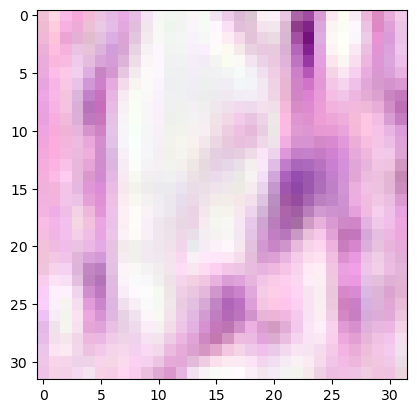

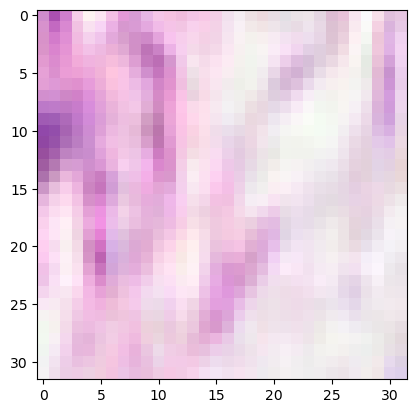

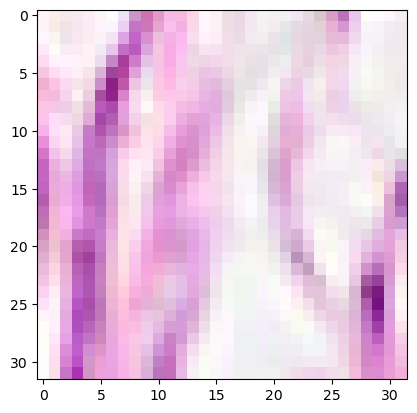

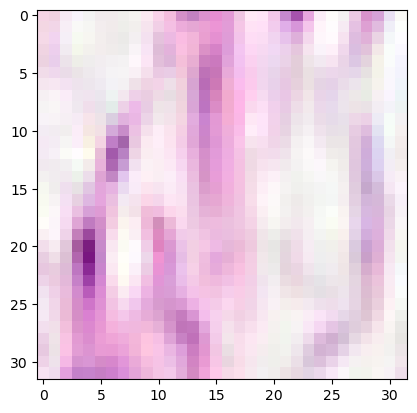

In [91]:
# TODO: replace with spatialdata-plot

import matplotlib.pyplot as plt
import spatialdata as sd
import spatialdata_plot

for sdata_tile, cell in zip(small_dataset, small_sdata["cell_boundaries"].geometry):
    img = sdata_tile["CytAssist_FFPE_Human_Breast_Cancer_full_image"]
    t = sd.transformations.get_transformation(img, "aligned")
    # print(t.to_affine(input_axes=('x', 'y'), output_axes=('x', 'y')))
    plt.imshow(img.transpose("y", "x", "c"))
    # x = cell.exterior.xy[0]
    # y = cell.exterior.xy[1]
    plt.show()